In [18]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 12)

In [2]:
set.seed(16)
url <- "https://raw.githubusercontent.com/nchan315/DSCI_100_007_16_Project/main/superstore_data.csv"
data <- read_csv(url)

store_data <- data |>
    # removing rows with NA
    na.omit() |>

    # removing discrete variables
    select(-Id, -Education, -Complain) |>

    # summing the number of children
    mutate(Childhome = Kidhome + Teenhome) |>
    select(-Kidhome, -Teenhome) |>

    # creating an age column
    mutate(Age = 2022 - Year_Birth) |>
    select(-Year_Birth) |>

    # combining the amount spent on food
    mutate(Total_Spent = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts) |>
    select(-MntWines, -MntFruits, -MntMeatProducts, -MntFishProducts, -MntSweetProducts) |>

    # calculating weeks that the customer has been a customer
    mutate(Dt_Customer = as.Date(Dt_Customer, "%m/%d/%Y")) |>
    mutate(Weeks_Customer = difftime("2022-12-31", Dt_Customer, units = "weeks")) |>
    mutate(Weeks_Customer = as.numeric(Weeks_Customer)) |>
    select(-Dt_Customer) |>

    # changing martial status into 2 distinctions
    mutate(Relationship = case_when(Marital_Status == 'Married' | Marital_Status == 'Together' ~ 'Yes',
                                    Marital_Status !=  'Married' & Marital_Status != 'Together' ~ 'No')) |>
    select(-Marital_Status) |>
    mutate(Relationship = as.factor(Relationship)) |>

    # changing response to a factor
    mutate(Response = as.factor(Response))
store_data

Rows: 2240 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Education, Marital_Status, Dt_Customer
dbl (19): Id, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
store_data_reduced <- store_data |>
    select(Relationship, Income, Age, Childhome, Total_Spent, Weeks_Customer, Response)
glimpse(store_data_reduced)

Rows: 2,216
Columns: 7
$ Relationship   <fct> No, No, Yes, Yes, No, No, Yes, Yes, Yes, Yes, Yes, Yes,…
$ Income         <dbl> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 44931,…
$ Age            <dbl> 52, 61, 64, 55, 33, 64, 68, 55, 68, 68, 75, 43, 63, 41,…
$ Childhome      <dbl> 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2, 1, 1…
$ Total_Spent    <dbl> 972, 540, 221, 11, 57, 1149, 1150, 89, 539, 539, 1182, …
$ Weeks_Customer <dbl> 445.7143, 445.8571, 450.5714, 425.4286, 438.7143, 458.7…
$ Response       <fct> 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0…


In [6]:
# creating the 75% training 25% testing split
store_data_split <- initial_split(store_data_reduced, prop = 0.75, strata = Response)
store_data_train <- training(store_data_split) 
store_data_test <- testing(store_data_split)
store_data_train

Relationship,Income,Age,Childhome,Total_Spent,Weeks_Customer,Response
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Yes,67267,64,1,221,450.5714,0
Yes,44931,55,1,89,467.0000,0
Yes,65324,68,1,539,426.0000,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yes,77766,55,1,1502,514.1429,1
Yes,77766,55,1,1502,514.1429,1
Yes,94871,53,2,934,572.7143,1


In [12]:
# beginning of forward selection using training set (Yes Relationship)
training_yes <- store_data_train |>
    filter(Relationship == "Yes")

# getting column names
names <- colnames(store_data_train |> select(-Response, -Relationship))
names

[1] "Income"         "Age"            "Childhome"      "Total_Spent"   
[5] "Weeks_Customer"

In [13]:
# Code taken from 6.8 in online textbook
# (may take a while to run)

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
store_vfold <- vfold_cv(training_yes, v = 5, strata = Response)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Response", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        store_recipe <- recipe(as.formula(model_string), 
                                data = training_yes) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Response ~ Income,0.8875495
2,Response ~ Income+Weeks_Customer,0.8894100
3,Response ~ Income+Weeks_Customer+Total_Spent,0.8912661
4,Response ~ Income+Weeks_Customer+Total_Spent+Age,0.8875581
5,Response ~ Income+Weeks_Customer+Total_Spent+Age+Childhome,0.8894143


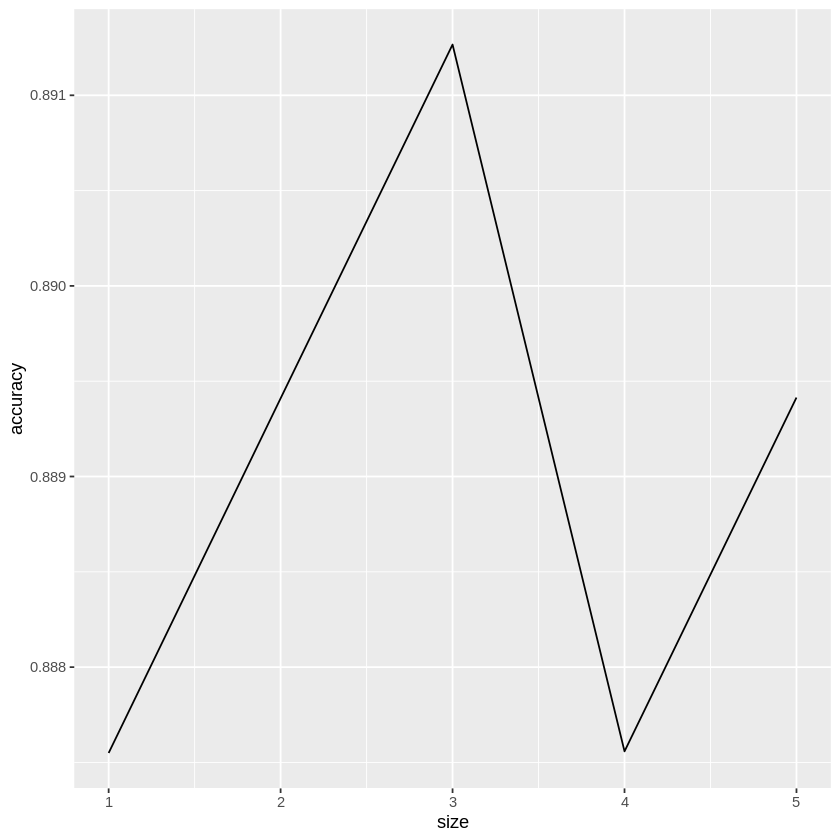

In [15]:
yes_plot <- accuracies |>
    ggplot(aes(size, accuracy)) +
        geom_line()
yes_plot

In [16]:
store_data_split <- initial_split(store_data, prop = 0.75, strata = Response)
store_data_train2 <- training(store_data_split)

store_data_train2_yes <- store_data_train2 |>
    filter(Relationship == "Yes")

# getting column names
names <- colnames(store_data_train2_yes |> select(-Response, -Relationship))
names

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
store_vfold <- vfold_cv(store_data_train2_yes, v = 5, strata = Response)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Response", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        store_recipe <- recipe(as.formula(model_string), 
                                data = store_data_train2_yes) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

[1] "Income"              "Recency"             "MntGoldProds"       
 [4] "NumDealsPurchases"   "NumWebPurchases"     "NumCatalogPurchases"
 [7] "NumStorePurchases"   "NumWebVisitsMonth"   "Childhome"          
[10] "Age"                 "Total_Spent"         "Weeks_Customer"

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Response ~ NumCatalogPurchases,0.8886855
2,Response ~ NumCatalogPurchases+NumWebVisitsMonth,0.8923849
3,Response ~ NumCatalogPurchases+NumWebVisitsMonth+Recency,0.8905288
⋮,⋮,⋮
10,Response ~ NumCatalogPurchases+NumWebVisitsMonth+Recency+NumDealsPurchases+NumStorePurchases+Childhome+NumWebPurchases+MntGoldProds+Income+Weeks_Customer,0.8905203
11,Response ~ NumCatalogPurchases+NumWebVisitsMonth+Recency+NumDealsPurchases+NumStorePurchases+Childhome+NumWebPurchases+MntGoldProds+Income+Weeks_Customer+Total_Spent,0.8895986
12,Response ~ NumCatalogPurchases+NumWebVisitsMonth+Recency+NumDealsPurchases+NumStorePurchases+Childhome+NumWebPurchases+MntGoldProds+Income+Weeks_Customer+Total_Spent+Age,0.8868591


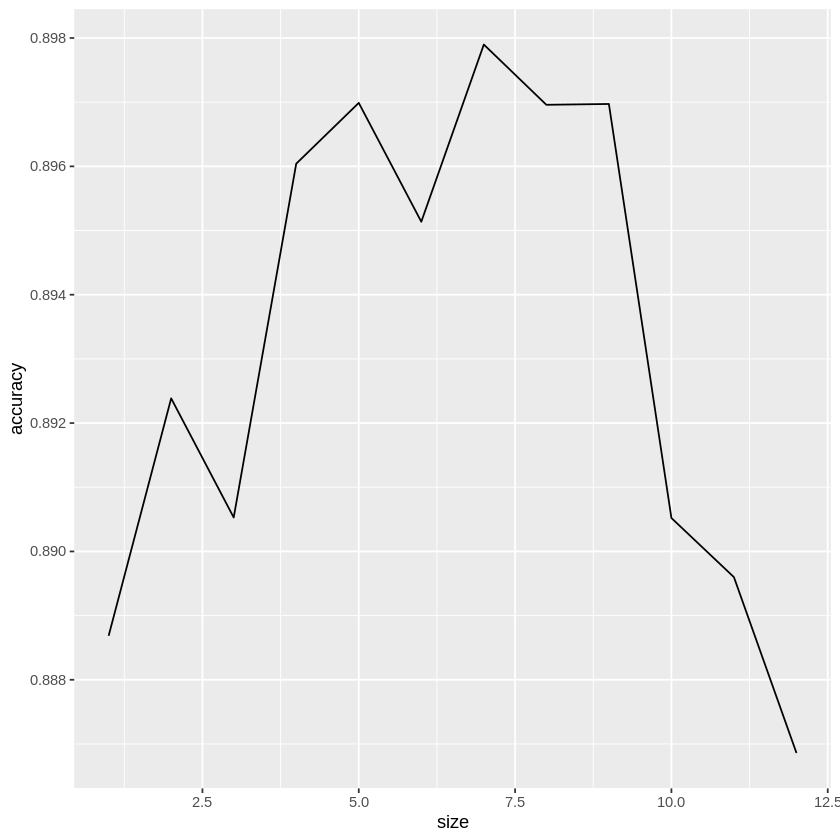

In [17]:
yes_plot <- accuracies |>
    ggplot(aes(size, accuracy)) +
        geom_line()
yes_plot

FOR YES RELATIONSHIP: use Income+Weeks_Customer+Total_Spent

FOR  NO RELATIONSHIP: use Income+Age+Weeks_Customer+Childhome

In [20]:
training_no <- store_data_train |>
    filter(Relationship == "No")
# getting column names
names <- colnames(store_data_train |> select(-Response, -Relationship))

In [21]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
store_vfold <- vfold_cv(training_no, v = 5, strata = Response)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Response", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        store_recipe <- recipe(as.formula(model_string), 
                                data = training_no) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Response ~ Income,0.7880072
2,Response ~ Income+Age,0.7982496
3,Response ~ Income+Age+Weeks_Customer,0.8017998
4,Response ~ Income+Age+Weeks_Customer+Childhome,0.8051604
5,Response ~ Income+Age+Weeks_Customer+Childhome+Total_Spent,0.7999153


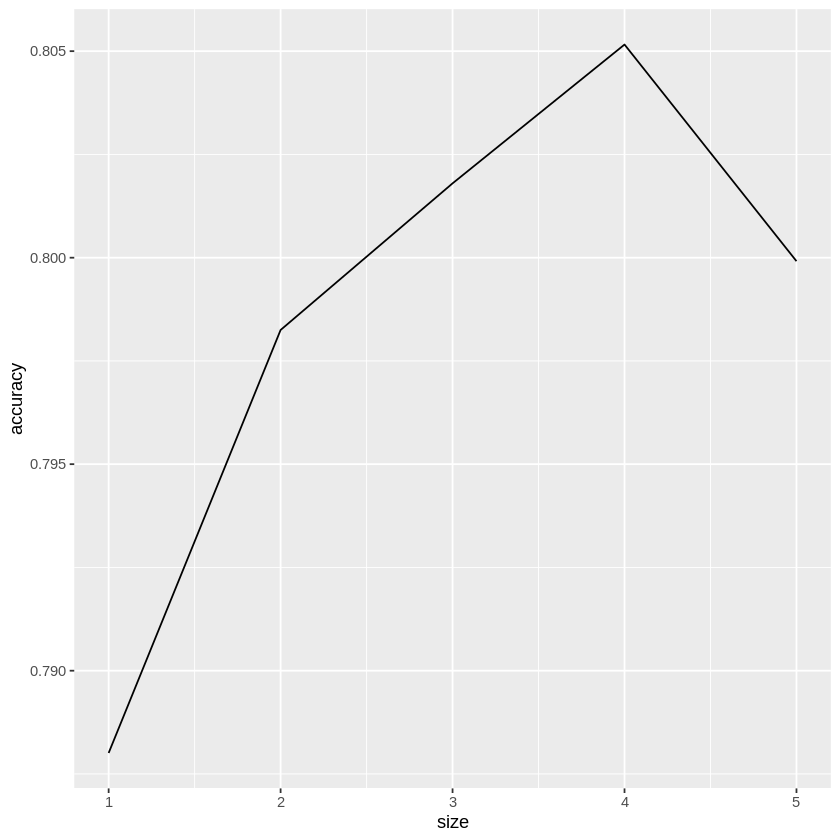

In [22]:
no_plot <- accuracies |>
    ggplot(aes(size, accuracy)) +
        geom_line()
no_plot